# Sochastic Gradient Descent with Model Building

### First, we install the SMB package.

In [1]:
!pip install git+https://github.com/sibirbil/SMB.git

  Cloning https://github.com/sibirbil/SMB.git to /private/var/folders/zy/87gspt1523z5dlb99f2955_m0000gn/T/pip-req-build-y77m4wbe
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [1]:
import torch
import torch.optim as optim

import time
import datetime
import numpy as np
import json
import matplotlib.pyplot as plt 

import smb
from smb import utils as ut

## Train options

In [2]:
# Epochs to train for
epochs = 20

# Dataset-Model
TrainOptions = {1:('mnist', 'mlp'), 
                2:('cifar10', 'resnet34_10'), 
                3:('cifar10', 'densenet10'), 
                4:('cifar100', 'resnet34_100'), 
                5:('cifar100', 'densenet10')
                }
dataset_name, model_name = TrainOptions[1]


# Batch Size
batch_size = 128


## Load dataset and the model

In [3]:
# Check if GPU is available
use_GPU = torch.cuda.is_available()


seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
    

# Get Dataset
train_set, test_set, train_loader = ut.get_dataset(dataset_name, batch_size)
n_batches_per_epoch = len(train_loader)

    
opt_out_list = []

0.1%

42.9%

Extracting Datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to Datasets/MNIST/raw



112.7%

Extracting Datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to Datasets/MNIST/raw



## Train with SMB optimizer

SMB optimizer requires a closure function. You can its form below.

In [ ]:
independent_batch = False
autoschedule = False

opt_out = {}

if independent_batch:
    opt_out.update({'name':'SMBi'})
else:
    opt_out.update({'name':'SMB'})

opt_out.update({'independent_batch':independent_batch, 
           'autoschedule':autoschedule, 
           'gamma':0.05, 
           'beta':0.9, 
           'lr':0.5, 
           'c':0.1, 
           'eta':0.99, 
           'data':dataset_name, 
           'model':model_name, 
           })

# Get Model
model = ut.get_model(model_name)
if use_GPU:
    model.cuda()
 
 
# loss function
criterion = ut.softmax_loss
 
optimizer = smb.SMB(model.parameters(), 
                lr=opt_out['lr'], 
                c=opt_out['c'], 
                eta=opt_out['eta'], 
                independent_batch=opt_out['independent_batch'], 
                autoschedule=opt_out['autoschedule'],
                n_batches_per_epoch=n_batches_per_epoch)

print('\n' + 'Starting to train with {} optimizer: For {} epochs'.format(opt_out['name'], epochs))

train_loss_list = []
test_acc_list = []
run_time_list = []


for epoch in range(1, epochs+1):
    
    step_type = []
        
    begin = time.time()
    
    # training steps
    model.train()
    
    for batch_index, (data, target) in enumerate(train_loader):
        
        # moves tensors to GPU if available
        if use_GPU:
            data, target = data.cuda(), target.cuda() 
            
        # create loss closure for smb algorithm
        def closure():
            optimizer.zero_grad()
            loss = criterion(model, data, target)
            return loss
        
        # forward pass
        loss = optimizer.step(closure=closure)
        
    end = time.time()
        
    train_loss = ut.compute_loss(model, train_set)
    test_acc = ut.compute_accuracy(model, test_set)
        
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    run_time_list.append(end-begin)
        
    # Display loss statistics
    print(f'Epoch: {epoch}   -   Training Loss: {round(train_loss, 6)}  -  Test Accuracy: {round(test_acc, 6)}  -  Time: {round(end-begin, 2)}')

    
opt_out.update({'train_loss':train_loss_list,
                 'test_acc':test_acc_list,
                 'run_time':run_time_list,
                })

opt_out_list.append(opt_out)


Starting to train with SMB optimizer: For 20 epochs
Epoch: 1   -   Training Loss: 0.159516  -  Test Accuracy: 0.9496  -  Time: 16.6
Epoch: 2   -   Training Loss: 0.096351  -  Test Accuracy: 0.9645  -  Time: 16.09
Epoch: 3   -   Training Loss: 0.10743  -  Test Accuracy: 0.9626  -  Time: 15.3
Epoch: 4   -   Training Loss: 0.07375  -  Test Accuracy: 0.9687  -  Time: 15.52
Epoch: 5   -   Training Loss: 0.043632  -  Test Accuracy: 0.9763  -  Time: 15.32


## Train with ADAM optimizer

In [6]:
opt_out = {'name':'Adam', 
           'lr':0.001, 
           'data':dataset_name, 
           'model':model_name,
           } 

# Get Model
model = ut.get_model(model_name)
if use_GPU:
    model.cuda()
 
# loss function
criterion = ut.softmax_loss

# optimizer
optimizer = optim.Adam(model.parameters(), lr = opt_out['lr'])


print('\n' + 'Starting to train with {} optimizer: For {} epochs'.format(opt_out['name'], epochs))


train_loss_list = []
test_acc_list = []
run_time_list = []
    

for epoch in range(1, epochs+1):
        
    begin = time.time()

    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):            
            
        # moves tensors to GPU
        if use_GPU:
            data, target = data.cuda(), target.cuda()     
        # clears gradients
        optimizer.zero_grad()
        # loss in batch
        loss = criterion(model, data, target)
        # backward pass for loss gradient
        loss.backward()
            
            
        # update paremeters
        optimizer.step()
            
    end = time.time()
    
    
    # Calculate metrics
    train_loss = ut.compute_loss(model, train_set)
    test_acc = ut.compute_accuracy(model, test_set)
    
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    run_time_list.append(end-begin)
        
    # Display loss statistics
    print(f'Epoch: {epoch}   -   Training Loss: {round(train_loss, 6)}   -   Test Accuracy: {round(test_acc, 6)}  -  Time: {round(end-begin, 2)}')


opt_out.update({'train_loss':train_loss_list,
                 'test_acc':test_acc_list,
                 'run_time':run_time_list,
                })

opt_out_list.append(opt_out)


Starting to train with Adam optimizer: For 20 epochs
Epoch: 1   -   Training Loss: 0.155025   -   Test Accuracy: 0.9535  -  Time: 11.68
Epoch: 2   -   Training Loss: 0.126146   -   Test Accuracy: 0.9559  -  Time: 11.86
Epoch: 3   -   Training Loss: 0.079501   -   Test Accuracy: 0.97  -  Time: 11.91
Epoch: 4   -   Training Loss: 0.067323   -   Test Accuracy: 0.9698  -  Time: 11.88
Epoch: 5   -   Training Loss: 0.051616   -   Test Accuracy: 0.972  -  Time: 11.85
Epoch: 6   -   Training Loss: 0.066012   -   Test Accuracy: 0.9692  -  Time: 11.85
Epoch: 7   -   Training Loss: 0.040421   -   Test Accuracy: 0.976  -  Time: 11.86
Epoch: 8   -   Training Loss: 0.028547   -   Test Accuracy: 0.9802  -  Time: 11.93
Epoch: 9   -   Training Loss: 0.030826   -   Test Accuracy: 0.9784  -  Time: 12.03
Epoch: 10   -   Training Loss: 0.042395   -   Test Accuracy: 0.9749  -  Time: 11.99
Epoch: 11   -   Training Loss: 0.02092   -   Test Accuracy: 0.9805  -  Time: 11.89
Epoch: 12   -   Training Loss: 0.029

## Train with SGD optimizer

In [7]:
opt_out = {'name':'SGD', 
           'lr':0.1, 
           'data':dataset_name, 
           'model':model_name,
           }

# Get Model
model = ut.get_model(model_name)
if use_GPU:
    model.cuda()
 
# loss function
criterion = ut.softmax_loss

# optimizer
optimizer = optim.SGD(model.parameters(), lr = opt_out['lr'])

print('\n' + 'Starting to train with {} optimizer: For {} epochs'.format(opt_out['name'], epochs))


train_loss_list = []
test_acc_list = []
run_time_list = []
    

for epoch in range(1, epochs+1):
        
    begin = time.time()

    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):            
            
        # moves tensors to GPU
        if use_GPU:
            data, target = data.cuda(), target.cuda()     
        # clears gradients
        optimizer.zero_grad()
        # loss in batch
        loss = criterion(model, data, target)
        # backward pass for loss gradient
        loss.backward()
            
            
        # update paremeters
        optimizer.step()
            
    end = time.time()
    
    
    # Calculate metrics
    train_loss = ut.compute_loss(model, train_set)
    test_acc = ut.compute_accuracy(model, test_set)
    
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    run_time_list.append(end-begin)
        
    # Display loss statistics
    print(f'Epoch: {epoch}   -   Training Loss: {round(train_loss, 6)}   -   Test Accuracy: {round(test_acc, 6)}  -  Time: {round(end-begin, 2)}')


opt_out.update({'train_loss':train_loss_list,
                 'test_acc':test_acc_list,
                 'run_time':run_time_list,
                })

opt_out_list.append(opt_out)


Starting to train with SGD optimizer: For 20 epochs
Epoch: 1   -   Training Loss: 0.2492   -   Test Accuracy: 0.9207  -  Time: 10.29
Epoch: 2   -   Training Loss: 0.165351   -   Test Accuracy: 0.9479  -  Time: 10.26
Epoch: 3   -   Training Loss: 0.111667   -   Test Accuracy: 0.9627  -  Time: 10.32
Epoch: 4   -   Training Loss: 0.090105   -   Test Accuracy: 0.9674  -  Time: 10.26
Epoch: 5   -   Training Loss: 0.082428   -   Test Accuracy: 0.9682  -  Time: 10.27
Epoch: 6   -   Training Loss: 0.060599   -   Test Accuracy: 0.9727  -  Time: 10.29
Epoch: 7   -   Training Loss: 0.050344   -   Test Accuracy: 0.9771  -  Time: 10.24
Epoch: 8   -   Training Loss: 0.064024   -   Test Accuracy: 0.9709  -  Time: 10.24
Epoch: 9   -   Training Loss: 0.043213   -   Test Accuracy: 0.9756  -  Time: 10.3
Epoch: 10   -   Training Loss: 0.035557   -   Test Accuracy: 0.9767  -  Time: 10.33
Epoch: 11   -   Training Loss: 0.042102   -   Test Accuracy: 0.9747  -  Time: 10.24
Epoch: 12   -   Training Loss: 0.02

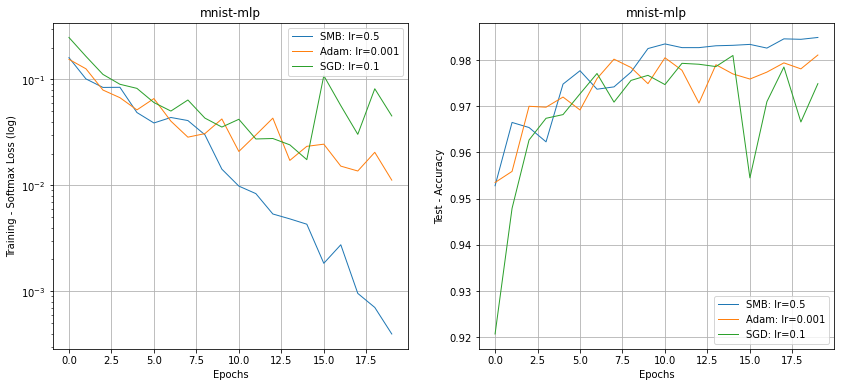

In [8]:
ut.show_loss_acc_graph(opt_out_list, "{}-{}".format(dataset_name, model_name))

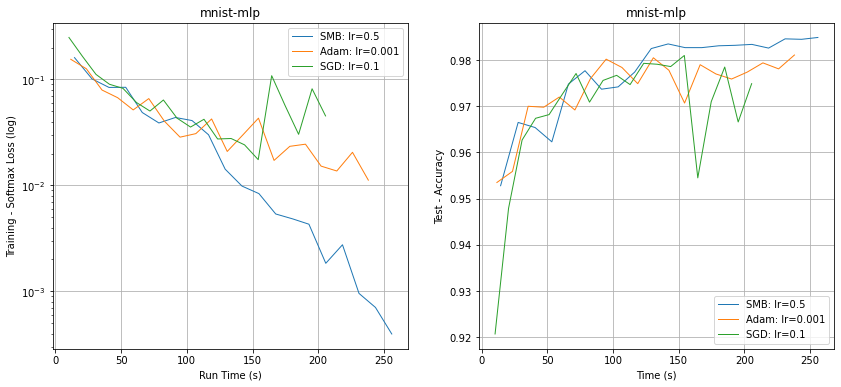

In [9]:
ut.show_time_graph(opt_out_list, "{}-{}".format(dataset_name, model_name))